# Decision tree step by step

In [179]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
##### GOOGLE COLAB ######
! wget https://raw.githubusercontent.com/davidggphy/2019_03_Curso_IFT/master/notebooks/01_classification/decision_trees_utils.py
! wget https://raw.githubusercontent.com/davidggphy/2019_03_Curso_IFT/master/notebooks/01_classification/plot_confusion_matrix.py

In [1]:
from decision_trees_utils import cart_plot,multiple_cart_plots,print_cart
from decision_trees_utils import number_of_splits
from plot_confusion_matrix import plot_confusion_matrix,plot_confusion_matrix2
from decision_trees_utils import tree_to_nodes

In [2]:
%matplotlib notebook
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns

In [3]:
import matplotlib as mpl
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import Range1d
output_notebook()

Loading BokehJS ...

## Creating the data

In [6]:
npoints1 = 30 # BLUE
npoints2 = 20 # RED

# Mean value and covariance matrices of the two classes
mu_vec1 = np.array([0,2])
cov_mat1 = np.array([[1,0],[0,4]])
mu_vec2 = np.array([4,0])
cov_mat2 = np.array([[3,0],[0,1]])

# We sample the points with numpy
np.random.seed(0)
x1_samples = np.random.multivariate_normal(mu_vec1, cov_mat1, npoints1)
mu_vec1 = mu_vec1.reshape(1,2).T # to 1-col vector
x2_samples = np.random.multivariate_normal(mu_vec2, cov_mat2, npoints2)
mu_vec2 = mu_vec2.reshape(1,2).T

X = np.vstack( (x1_samples,x2_samples)  )
Y = np.hstack((np.ones(len(x2_samples)),np.zeros(len(x1_samples))))


xrange = (X[:,0].min()-0.5,X[:,0].max()+0.5)
yrange = (X[:,1].min()-0.5,X[:,1].max()+0.5)



# Train Test Split
X_train,X_test,Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

In [7]:
x = X_train[:,0] 
y = X_train[:,1] 
colors = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g ,b  in 150*np.eye(3)[[0,2,1]][np.array(Y_train,dtype='int')]
]
x_test = X_test[:,0] 
y_test = X_test[:,1] 
colors_test = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g ,b  in 150*np.eye(3)[[0,2,1]][np.array(Y_test,dtype='int')]
]

In [9]:
p = figure()
p.x_range = Range1d(xrange[0],xrange[1])
p.y_range = Range1d(yrange[0],yrange[1])
# TRAIN
p.scatter(x, y, radius = 0.07, # radius=radii,
          fill_alpha=0.7, fill_color = colors, # fill_color=colors, 
          line_color=None, )
# TEST
p.scatter(x_test, y_test, radius = 0.07, # radius=radii,
          fill_alpha=0.1, fill_color = colors_test, # fill_color=colors, 
          line_color=None)
show(p)

## Logistic Regression with sklearn

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
clf_log = LogisticRegression(solver='lbfgs').fit(X_train,Y_train)

We can extract the coefficients of the linear regression to plot the decision boundary

In [35]:
b0, b1 = tuple(clf_log.coef_[0])
p1 = (xrange[0],b0+b1*xrange[0]) # x,y point
p2 = (xrange[1],b0+b1*xrange[1]) # x,y point
line = [list(x) for x in zip(p1,p2)] # This defines the line

In [15]:
p = figure()
p.x_range = Range1d(xrange[0],xrange[1])
p.y_range = Range1d(yrange[0],yrange[1])
# TRAIN
p.scatter(x, y, radius = 0.07, # radius=radii,
          fill_alpha=0.7, fill_color = colors, # fill_color=colors, 
          line_color=None, )
# TEST
p.scatter(x_test, y_test, radius = 0.07, # radius=radii,
          fill_alpha=0.1, fill_color = colors_test, # fill_color=colors, 
          line_color=None)
# LINE
p.line(line[0],line[1], line_width=2, line_color = 'black')
show(p)

## Classification Decision Tree with Sklearn

In [16]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini').fit(X_train, Y_train)
clf1 = tree.DecisionTreeClassifier(min_samples_split=5).fit(X_train, Y_train)
clf2 = tree.DecisionTreeClassifier(max_depth=4).fit(X_train, Y_train)

### Plotting the final decision boundaries

In [17]:
# radii = np.random.random(size=N) * 1.5
# colors = [
#     "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g, b, _ in 255*mpl.cm.viridis(mpl.colors.Normalize()(radii))
# ]
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=TOOLS)
# TRAIN
p.scatter(x, y, radius = 0.07, # radius=radii,
          fill_alpha=0.7, fill_color = colors, # fill_color=colors, 
          line_color=None, )
# TEST
p.scatter(x_test, y_test, radius = 0.07, # radius=radii,
          fill_alpha=0.1, fill_color = colors_test, # fill_color=colors, 
          line_color=None)

cart_plot(clf, xrange,yrange,feature_names=['X0','X1'],plot=p)

In [18]:
clf.feature_importances_

array([0.15625, 0.84375])

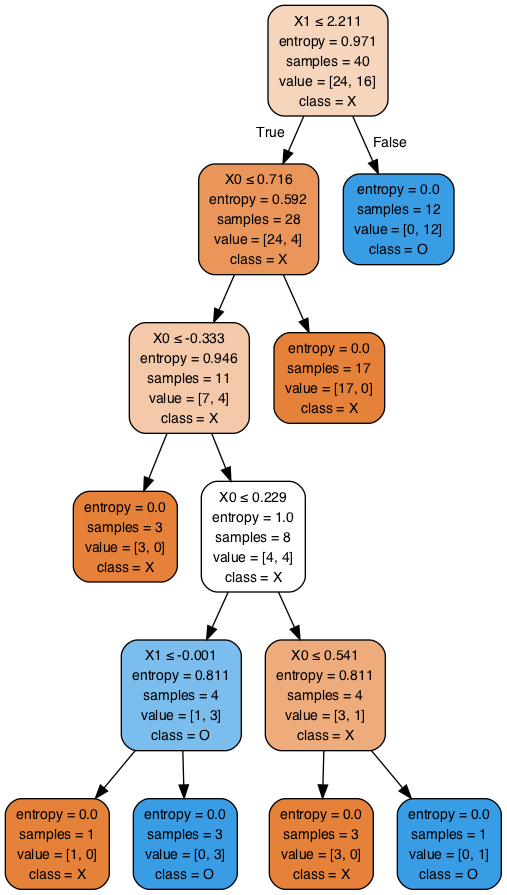

In [144]:
print_cart(clf,feature_names=['X0','X1'])

**Properties:**
- The decision tree behaves as a nested set of if else conditions.
- Interpretable (at least the first nodes)
    -  We can know why we got a prediction
    -  Contrast with common sense and domain knowledge
- Decision trees will overfit
- But will generalize using next parameters:
    -  min_samples_leaf
    -  min_samples_split 
    -  max_depth 
    -  max_leaf_nodes
- Compared to a plain logistic regression, decision trees are slower (no vectorization), but really fast (we can do hyperparameter optimization)
- We have many hyperparameters (size of data, depth of tree, etc)
- No standarization / normalization (Using original units we will be able to understand the tree better)
- Remember that decision boundaries are always orthogonal to the axis, PCA can be useful
- Feature selection for free (not used if it not important clf.feature_importances_)
- Ordinal categorical variables are treated nicely (They have an intrinsic order, and grouped with neighbours)
- Low stability (Small changes in data, can cause a big change in the model)


## Ipywidgets

For the following, Ipywidgets must be installed and properly configured in jupyter.

In [ ]:
! pip install ipywidgets
! jupyter nbextension enable --py widgetsnbextension

In [19]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from bokeh.models import LassoSelectTool,WheelZoomTool,SaveTool,CrosshairTool,HoverTool,PanTool,TapTool

In [20]:
n_splits = number_of_splits(clf)

In [21]:
@interact
def show_articles_more_than(step=(0,n_splits,1)):
    colors = [
    "#%02x%02x%02x" % (int(r), int(g), int(b)) for r, g ,b  in 150*np.eye(3)[[0,2,1]][np.array(Y_train,dtype='int')]
]
    l_plots = multiple_cart_plots(clf, xrange,yrange,feature_names=['X0','X1'])
    plot = l_plots[step]
    plot.scatter(x, y, radius = 0.07, # radius=radii,
          fill_alpha=0.6, fill_color = colors, # fill_color=colors, 
          line_color=None)
    plot.x_range = Range1d(xrange[0],xrange[1])
    plot.y_range = Range1d(yrange[0],yrange[1])
    plot.add_tools(CrosshairTool())
    plot.add_tools(HoverTool())
    plot.add_tools(TapTool())
    show(plot)
    return None

interactive(children=(IntSlider(value=2, description='step', max=4), Output()), _dom_classes=('widget-interact…

## Decision Tree from scratch

In [22]:
from collections import namedtuple
class Node(namedtuple('Node', 'feature, threshold, left_node, right_node')):
    pass

In [26]:
import math
def entropy(a, b): 
    total = a + b
    prob_a = a / total
    prob_b = b / total
    ent = - prob_a * math.log(prob_a+1e-10, 2) - prob_b * math.log(prob_b+1e-10, 2)
    return ent

In [27]:
def get_best_split(x, y, class_a_value=0, class_b_value=1):
    best_split = None
    best_entropy = 1.
    for feature in x.columns.values: # feature is the string naming each input feature
        column = x[feature] # This is the array of the values
        for value in column:
            a = y[column < value] == class_a_value 
            b = y[column < value] == class_b_value
            na = np.sum(a)
            nb = np.sum(b)
            left_weight = (na + nb) / len(y) 
            left_entropy = entropy(na, nb)
            a = y[column >= value] == class_a_value 
            b = y[column >= value] == class_b_value 
            na = np.sum(a)
            nb = np.sum(b)
            right_weight = (na + nb) / len(y) 
            right_entropy = entropy(na, nb)
            split_entropy = left_weight * left_entropy + right_weight * right_entropy 
            if split_entropy < best_entropy:
                best_split = (feature, value) 
                best_entropy = split_entropy
    return best_split

In [28]:
def train_decision_tree(x, y, class_a_value=0, class_b_value=1):
    feature, value = get_best_split(x, y, class_a_value=class_a_value,class_b_value=class_b_value)
    x_left, y_left = x[x[feature] < value], y[x[feature] < value] 
    if len(np.unique(y_left))  > 1:
        left_node = train_decision_tree(x_left, y_left) 
    else:
        left_node = None
    x_right, y_right = x[x[feature] >= value], y[x[feature] >= value] 
    if len(np.unique(y_right)) > 1:
        right_node = train_decision_tree(x_right, y_right) 
    else:
        right_node = None
    return Node(feature, value, left_node, right_node)

Converting the data into the right type

In [29]:
import pandas as pd
df_x = pd.DataFrame({'X0':X_train[:,0],'X1':X_train[:,1]})

In [30]:
get_best_split(df_x,Y_train,0,1)

/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.
/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


('X1', 2.288087142321756)

In [31]:
nodes = train_decision_tree(df_x,Y_train)

/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.
/Users/danky/anaconda3/envs/ML_Course/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in long_scalars
  """


In [32]:
nodes

Node(feature='X1', threshold=2.288087142321756, left_node=Node(feature='X0', threshold=0.7774903558319101, left_node=Node(feature='X0', threshold=-0.30230275057533557, left_node=None, right_node=Node(feature='X0', threshold=0.3024718977397814, left_node=Node(feature='X1', threshold=1.2253463651840955, left_node=None, right_node=None), right_node=Node(feature='X0', threshold=0.6536185954403606, left_node=None, right_node=None))), right_node=None), right_node=None)

We can compare it with the sklearn one

In [33]:
clf_ent = tree.DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
tree_to_nodes(clf_ent)

[Node(feature='X1', threshold=2.2105607986450195, left=1, right=12),
 Node(feature='X0', threshold=0.7155544757843018, left=2, right=11),
 Node(feature='X0', threshold=-0.3325219601392746, left=3, right=4),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature='X0', threshold=0.22941043972969055, left=5, right=8),
 Node(feature='X1', threshold=-0.0012246966361999512, left=6, right=7),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature='X0', threshold=0.5409752279520035, left=9, right=10),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1),
 Node(feature=None, threshold=-2.0, left=-1, right=-1)]

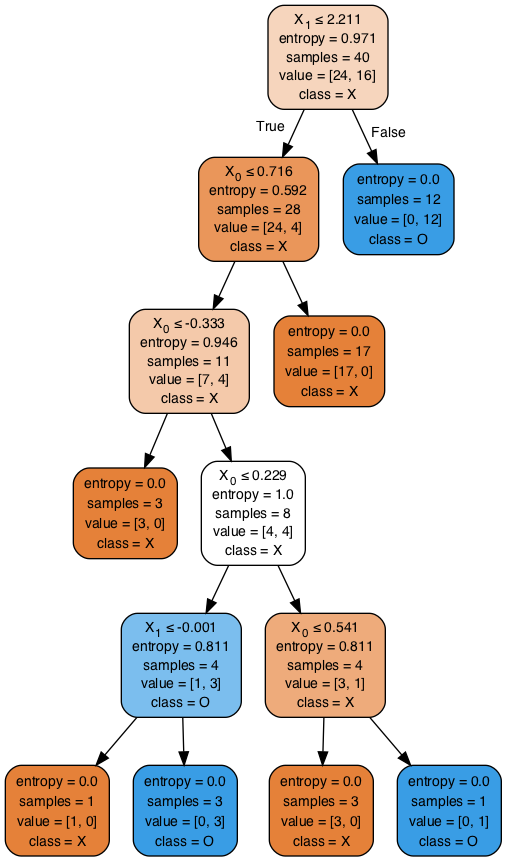

In [34]:
print_cart(clf_ent)

## Exercise: 

Implement the Decission Tree Classifier using the gini index instead of the entropy

In [ ]:
def gini(a, b): 
    ### TODO
    return gin

## Another implementation
https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/

In [236]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini
 
# Select the best split point for a dataset
def get_split(dataset):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	for index in range(len(dataset[0])-1):
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left)
		split(node['left'], max_depth, min_size, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right)
		split(node['right'], max_depth, min_size, depth+1)
 
# Build a decision tree
def build_tree(train, max_depth, min_size):
	root = get_split(train)
	split(root, max_depth, min_size, 1)
	return root
 
# Print a decision tree
def print_tree(node, depth=0):
	if isinstance(node, dict):
		print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
		print_tree(node['left'], depth+1)
		print_tree(node['right'], depth+1)
	else:
		print('%s[%s]' % ((depth*' ', node)))
 

dataset = np.hstack([X_train,Y_train.reshape((-1,1))])
tree = build_tree(dataset, 15, 5)
print_tree(tree)

[X2 < 2.288]
 [X2 < 1.225]
  [X2 < -1.726]
   [1.0]
   [X1 < 0.387]
    [0.0]
    [X1 < 0.387]
     [0.0]
     [0.0]
  [X1 < 0.302]
   [1.0]
   [0.0]
 [X1 < -0.977]
  [1.0]
  [X1 < -0.977]
   [1.0]
   [1.0]


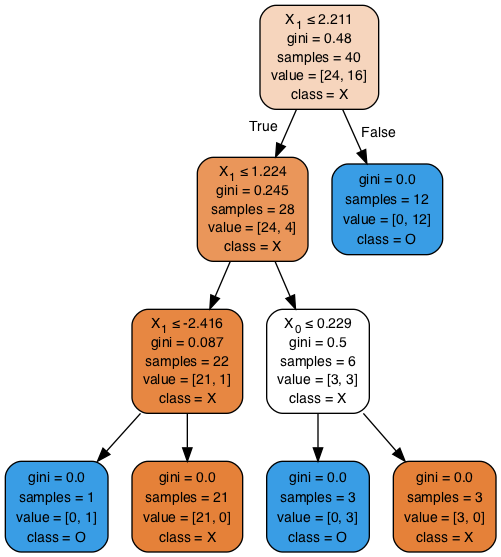

In [230]:
print_cart(clf)